In [38]:
#@title Import necessary packages and set correct device

import time

import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from modules.refcocog import RefCOCOg, RefCOCOgSample
from modules.yoloclip import display_preds
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.measure import regionprops
from skimage.segmentation import slic, watershed
from skimage.util import img_as_float
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import random_split
from torchvision.ops import box_iou
from tqdm import tqdm

%matplotlib inline

if torch.cuda.is_available():
    device = torch.device("cuda")  # CUDA GPU
    print("[INFO] Using cuda.")
elif torch.has_mps:
    device = torch.device("mps")  # Apple Silicon GPU
    print("[INFO] Using MPS.")
else:
    device = torch.device("cpu")
    print("[INFO] No GPU found, using CPU instead.")


[INFO] Using cuda.
[INFO] Using cuda.
[INFO] Using cuda.


In [39]:
#@title Import RefCOCOg dataset and its train/val/test splits

# data_path = "/media/dmmp/vid+backup/Data/refcocog"
data_path = "dataset/refcocog"

dataset = RefCOCOg(ds_path=data_path)

train_ds = RefCOCOg(ds_path=data_path, split='train')
val_ds = RefCOCOg(ds_path=data_path, split='val')
test_ds = RefCOCOg(ds_path=data_path, split='test')

# keep only a toy portion of each split
keep = 0.1
red_dataset, _ = random_split(dataset, [int(keep * len(dataset)), len(dataset) - int(keep * len(dataset))])
red_train_ds, _ = random_split(train_ds, [int(keep * len(train_ds)), len(train_ds) - int(keep * len(train_ds))])
red_val_ds, _ = random_split(val_ds, [int(keep * len(val_ds)), len(val_ds) - int(keep * len(val_ds))])
red_test_ds, _ = random_split(test_ds, [int(keep * len(test_ds)), len(test_ds) - int(keep * len(test_ds))])

print(f"[INFO] Dataset Size: {len(dataset)}")
print(f"[INFO] train split:  {len(train_ds)}")
print(f"[INFO] val split:    {len(val_ds)}")
print(f"[INFO] test split:   {len(test_ds)}")


Dataset Size: 49822

Train size: 42226
Val size:   2573
Test size:  5023
Dataset Size: 49822

Train size: 42226
Val size:   2573
Test size:  5023
Dataset Size: 49822

Train size: 42226
Val size:   2573
Test size:  5023


In [41]:
#@title Utility function to downsample a map

def downsample_map(map, factor):
    # number of blocks in each dimension
    blocks_h = map.shape[0] // factor
    blocks_w = map.shape[1] // factor

    # reshape the original matrix into blocks
    blocks = map[:blocks_h * factor, :blocks_w * factor].reshape(blocks_h, factor, blocks_w, factor)

    # calculate the average of each block
    averages = blocks.mean(axis=(1, 3))

    return averages


In [55]:
#@ Utility function to perform best bounding box search

def find_best_bbox(heatmap, show=False):
    heatmap = heatmap.astype(np.uint8)

    # Threshold the image to create a binary mask
    ret, mask = cv2.threshold(heatmap, heatmap.min(), heatmap.max(), cv2.THRESH_BINARY)

    # Find contours in the binary mask
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # print(f"[INFO] {len(contours)} detections.")

    best_score = 0
    best_bbox = None

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        score = heatmap[y:y + h, x:x + w].sum()
        if score > best_score:
            best_score = score
            best_bbox = (x, y, w, h)

    if show:
        # Display the map with the best bbox
        x, y, w, h = best_bbox
        rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor=(0, 1, 0), facecolor='none')
        plt.gca().add_patch(rect)
        plt.imshow(map)
        plt.axis("off")
        plt.show()

    return best_bbox

def quality_f(matrix):

    return matrix.sum()

    # ths = matrix.min()
    #
    # if matrix[matrix > ths].size == 0:
    #     return 0
    #
    # lit_area = np.sum(matrix > ths) / matrix.size
    # area_score = matrix[matrix > ths].sum()
    #
    # return lit_area * area_score


def find_best_bbox(heatmap):

    # Rescale the heatmap to [-1, 1]
    heatmap = MinMaxScaler(feature_range=(-1, 1)).fit_transform(heatmap)

    # Initialize the best score and best box
    best_score = float('-inf')
    best_box = None

    # Loop over all possible box sizes and positions
    for w in range(1, heatmap.shape[1] + 1):
        for h in range(1, heatmap.shape[0] + 1):
            for i in range(heatmap.shape[1] - w + 1):
                for j in range(heatmap.shape[0] - h + 1):

                    # Get current sub-region
                    candidate = heatmap[j:j + h, i:i + w]

                    # Compute the score for this box
                    score = quality_f(candidate)

                    # Update the best score and best box if necessary
                    if score > best_score:
                        best_score = score
                        # best_box = (i, j, w, h)
                        best_box = (i, j, w, h)

    return best_box


In [56]:
#@ Definition of Segmentation + CLIP visual grounding pipeline

class ClipSeg:

    def __init__(self, methods, n_segments=None, q=0.95, d=16, device=device, quiet=False):

        self.methods = list(methods)
        self.clip_model, self.clip_prep = clip.load("ViT-L/14", device=device)
        self.n_segments = n_segments
        self.q = q
        self.d = d
        self.device = device
        self.quiet = quiet

        supported_methods = ["s", "w"]

        for method in self.methods:
            if method not in supported_methods:
                raise ValueError(f"Method `{method}` not supported. Supported methods are: {supported_methods}")

    def _compute_hmap(self, img_sample, np_image, prompt, method, masks):

        hmaps = list()

        for i, n in enumerate(masks):

            if method == "s":  # slic
                segments = slic(np_image, n_segments=n, compactness=10, sigma=1)
            elif method == "w":  # watershed
                segments = watershed(sobel(rgb2gray(np_image)), markers=n, compactness=0.001)

            regions = regionprops(segments)
            if len(regions) == 1:
                # sometimes, with low-segments masks, the algorithm could return only one region,
                # which may not be very useful for our purposes. Let's simply skip these occurrences
                continue

            prompt_tkn = clip.tokenize(prompt).to(self.device)

            with torch.no_grad():
                prompt_enc = self.clip_model.encode_text(prompt_tkn)

            images_encs = list()

            pbar = tqdm(regions, position=0, leave=False) if not self.quiet else regions

            for region in pbar:

                if not self.quiet:
                    pbar.set_description(f"[INFO] method \"{method.upper()}\" "
                                         f"| mask {i + 1}/{len(self.n_segments)} "
                                         f"| computing CLIP scores",
                                         refresh=True)

                rect = region.bbox
                rect = (rect[1], rect[0], rect[3], rect[2])

                sub_image = img_sample.img.crop(rect)
                sub_image = self.clip_prep(sub_image).unsqueeze(0)
                sub_image = sub_image.to(self.device)

                with torch.no_grad():
                    image_enc = self.clip_model.encode_image(sub_image)

                images_encs.append(image_enc)

            images_encs = torch.cat(images_encs, dim=0)

            scores = prompt_enc @ images_encs.T

            scores = scores.squeeze().cpu().numpy()

            heatmap = np.zeros((segments.shape[0], segments.shape[1]))

            for i in range(segments.shape[0]):
                for j in range(segments.shape[1]):
                    heatmap[i, j] = scores[segments[i, j] - 1]

            hmaps.append(heatmap)

        return np.mean(np.array(hmaps), axis=0), hmaps

    def __call__(self, img_sample, prompt, show=False, show_pipeline=False, show_masks=False, timeit=False):

        if timeit:
            start = time.time()

        # Convert image to np array
        np_image = img_as_float(io.imread(img_sample.path))

        # Apply all methods requested
        all_p_heatmaps = list()
        all_heatmaps = list()

        for method in self.methods:
            p_heatmap, heatmaps = self._compute_hmap(img_sample, np_image, prompt, method, self.n_segments)
            all_p_heatmaps.append(p_heatmap)
            all_heatmaps.append(heatmaps)

        p_heatmap = np.mean(np.array(all_p_heatmaps), axis=0)

        # Shut down pixels below a certain threshold
        ths = np.quantile(p_heatmap.flatten(), self.q)
        fp_heatmap = p_heatmap.copy()
        fp_heatmap[p_heatmap < ths] = ths

        # Downsample the heatmap by a factor d
        dfp_heatmap = downsample_map(fp_heatmap, self.d)

        # Find the best bounding box
        pred_bbox = find_best_bbox(dfp_heatmap)

        if pred_bbox is None:
            return {"IoU": 0}

        if self.d > 1:
            pred_bbox = [pred_bbox[0] * self.d + self.d // 2,
                         pred_bbox[1] * self.d + self.d // 2,
                         pred_bbox[2] * self.d - self.d // 2,
                         pred_bbox[3] * self.d - self.d // 2]

        # Convert bbox format
        pred_bbox = [pred_bbox[0], pred_bbox[1], pred_bbox[2] + pred_bbox[0], pred_bbox[3] + pred_bbox[1]]

        # Get ground truth bbox
        gt_bbox = img_sample.bbox

        # Compute IoU
        iou = box_iou(
            torch.tensor([pred_bbox]),
            torch.tensor([gt_bbox])
        )

        # Show all masks, if requested
        if show_masks:
            for i, heatmaps in enumerate(all_heatmaps):

                fig, axes = plt.subplots(1, len(heatmaps), figsize=(20, 5))

                for ax in axes.ravel():
                    ax.axis("off")

                for j, heatmap in enumerate(heatmaps):
                    axes[j].imshow(np_image, alpha=0.25)
                    axes[j].imshow(heatmap, alpha=0.75)
                    axes[j].set_title(f"#{j + 1} ({self.methods[i]})")

        # Show the mask processing pipeline, if requested
        if show_pipeline:
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))

            for ax in axes.ravel():
                ax.axis("off")

            axes[0].imshow(np_image)
            axes[0].set_title("original image")
            axes[1].imshow(np_image, alpha=0.25)
            axes[1].imshow(p_heatmap, alpha=0.75)
            axes[1].set_title("pooled heatmap")
            axes[2].imshow(np_image, alpha=0.25)
            axes[2].imshow(fp_heatmap, alpha=0.75)
            axes[2].set_title("filtered heatmap")
            axes[3].imshow(np_image, alpha=0.25)
            dfp_heatmap_ = cv2.resize(dfp_heatmap, (np_image.shape[1], np_image.shape[0]), interpolation=cv2.INTER_LINEAR)
            axes[3].imshow(dfp_heatmap_, alpha=0.75)
            axes[3].set_title("dsampled heatmap")

        # Show the final prediction, if requested
        if show:
            display_preds(img_sample.img, prompt, pred_bbox, img_sample.bbox, f"{''.join(self.methods).upper()} + CLIP")

        if timeit:
            end = time.time()
            print(f"[INFO] Time elapsed: {end - start:.2f}s")

        return {"IoU": float(iou.item())}


/home/disi/visual-grounding/modules/utilities.py:46: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.text(pred_bbox[0], pred_bbox[1], "predicted", color=(1, 1, 1),
/home/disi/visual-grounding/modules/utilities.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.text(gt_bbox[0], gt_bbox[3], "true", color=(1, 1, 1),


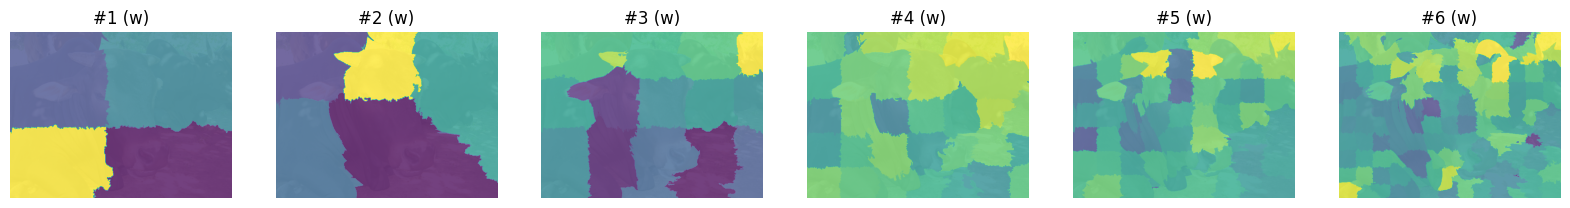

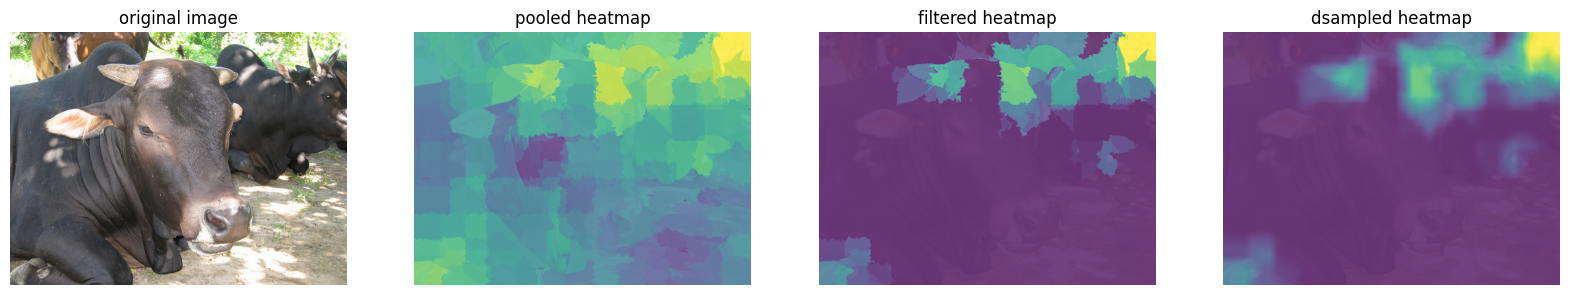

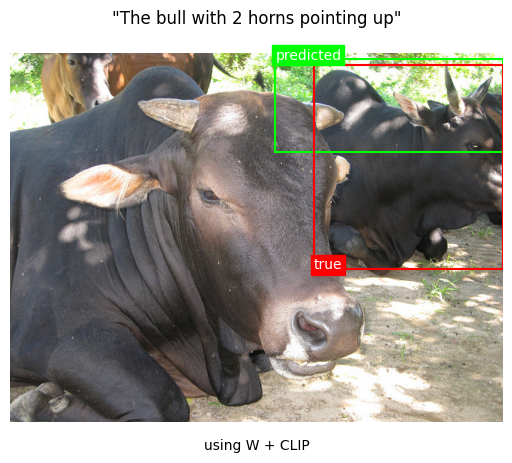

[INFO] Time elapsed: 17.12s


{'IoU': 0.38055723905563354}

In [57]:
#@tile Test ClipSeg on a random sample

# idx = np.random.randint(0, len(dataset))

sample = RefCOCOgSample(**dataset[idx])

clipseg = ClipSeg(methods="w", n_segments=(4, 8, 16, 32, 64, 128), q=0.75, quiet=True)

clipseg(sample, sample.sentences[0], show_pipeline=True, show_masks=True, show=True, timeit=True)


---

In [11]:
#@title Function definition to test visual grounding with a given pipeline

def visual_grounding_test(vg_pipeline, dataset, track="IoU"):
    scores = list()

    pbar = tqdm(dataset)

    for sample in pbar:

        sample = RefCOCOgSample(**sample)

        for sentence in sample.sentences:

            sc = vg_pipeline(sample, sentence, show=False)

            scores.append(sc)

            avg_score = np.mean([score[track] for score in scores])

            pbar.set_description(f"Average {track}: {avg_score:.3f}")

    for metric in scores[0].keys():
        avg_metric = np.mean([score[metric] for score in scores])

        print("Avg. {}: {:.3f}".format(metric, avg_metric))


In [ ]:
clipslic = ClipSeg(methods="w", n_segments=(4, 8, 16, 32, 64, 128), q=0.75, quiet=True)

visual_grounding_test(clipslic, red_test_ds, track="IoU")